In [2]:
# 导入包
# This makes it so that matplotlib graphics will show up within the Jupyter Notebook.
%matplotlib inline

# Standard library import

# Data Analysis Tools
import pandas as pd
import numpy as np

# Visualization Tools
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Tools
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


# File Loading Tools 
import os, sys
import pickle

print(os.getcwd())
sys.path.insert(1, '../data/')

/Users/diany/Documents/Python/Phm 2016 test1/code


In [3]:
X_train = np.load("../data/trainx_runpath1_50.npy")
y_train = np.load("../data/trainy_runpath1_50.npy")
X_test = np.load("../data/testx_runpath1_50.npy")
y_test = np.load("../data/testy_runpath1_50.npy")
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (798, 50, 17)
y_train shape:  (798, 1)
X_test shape:  (165, 50, 17)
y_test shape:  (165, 1)


In [4]:
# 基本参数
wafer_number, collecting_number, variable_number = X_train.shape
wafer_number_test = X_test.shape[0]
print('训练集晶圆个数：', wafer_number)
print('时间序列长度：', collecting_number)
print('字段个数：', variable_number)
print('训练集晶圆个数：', wafer_number_test)

训练集晶圆个数： 798
时间序列长度： 50
字段个数： 17
训练集晶圆个数： 165


In [5]:
# reshape X for conv2d
X_train_r = X_train.reshape((wafer_number, collecting_number, variable_number, 1))
X_test_r = X_test.reshape((wafer_number_test, collecting_number, variable_number, 1))
print('X_train_r shape: ', X_train_r.shape)
print('X_test_r shape: ', X_test_r.shape)

X_train_r shape:  (798, 50, 17, 1)
X_test_r shape:  (165, 50, 17, 1)


In [6]:
def plot_curve(expected, predicted):
    # 绘制预测值图像和实值图像
    plt.figure(figsize=(15,3))
    plt.plot(np.arange(len(expected)),expected,color='blue',linewidth=1.0,linestyle='-',label='true value')
    plt.plot(np.arange(len(predicted)),predicted,color='red',linewidth=1.0,linestyle='-',label='predict value')
    plt.title('prediction curve')
    plt.legend(loc='upper right') 
    plt.show()
    
    print('MSE: ', mean_squared_error(expected, predicted))  # 均方误差，越小越好
    print('RMSE: ', np.sqrt(mean_squared_error(expected, predicted)))  # 根均方误差，越小越好
    print('MAE: ', mean_absolute_error(expected, predicted))  # 平均绝对误差，越小越好
    print('R^2: ', r2_score(expected, predicted))  # r2 score 满分1，越接近1越好

## conv2d

In [7]:
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Conv2D, Dropout, MaxPool2D, AveragePooling2D
from keras.optimizers import SGD, Adam, Adagrad
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

2023-04-29 21:10:32.108172: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
def conv_built(conv_layers, input_shape):
    model = Sequential()
    for i in range(conv_layers):
        if i == 0:
            model.add(Conv2D(filters=16*(i+1), kernel_size=[2, 2], padding='same', input_shape=input_shape, name='conv2d{}'.format(i+1)))
        else:
            model.add(Conv2D(filters=16*(i+1), kernel_size=[2, 2], padding='same', input_shape=input_shape, name='conv2d{}'.format(i+1)))
        model.add(Activation('relu' , name='active{}'.format(i+1)))
        model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool{}'.format(i+1)))

    model.add(Flatten(name='flatten'))

    return model


def mlp_built(model, mlp_layers):
    for i in range(mlp_layers):
        model.add(Dense(4**(mlp_layers-1-i), name='dense{}'.format(i+1)))
        model.add(Activation('relu', name='active_dense{}'.format(i+1)))

    return model


def model_built(conv_layers=3, input_shape=(collecting_number, variable_number, 1), mlp_layers=5):
    model = conv_built(conv_layers, input_shape)
    model = mlp_built(model, mlp_layers)

    print(model.summary())

    return model




Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d1 (Conv2D)            (None, 50, 17, 16)        80        
                                                                 
 active1 (Activation)        (None, 50, 17, 16)        0         
                                                                 
 pool1 (AveragePooling2D)    (None, 25, 9, 16)         0         
                                                                 
 conv2d2 (Conv2D)            (None, 25, 9, 32)         2080      
                                                                 
 active2 (Activation)        (None, 25, 9, 32)         0         
                                                                 
 pool2 (AveragePooling2D)    (None, 13, 5, 32)         0         
                                                                 
 flatten (Flatten)           (None, 2080)             

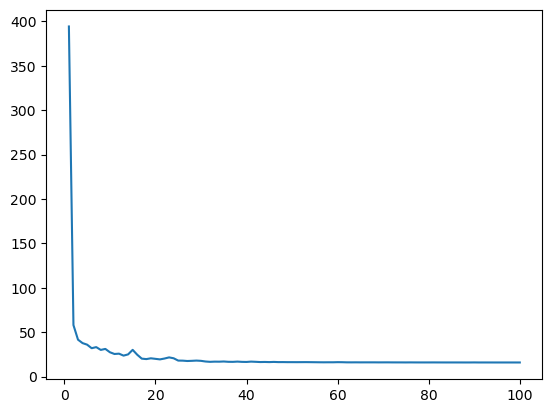

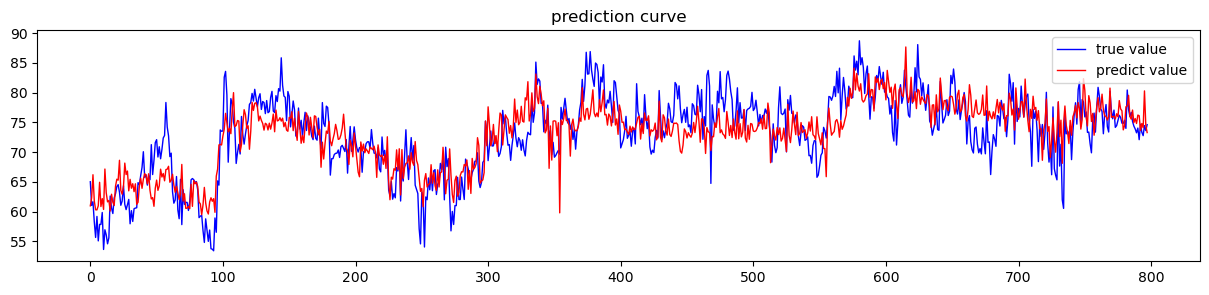

MSE:  15.835560742496067
RMSE:  3.9793920066382085
MAE:  3.141571045594945
R^2:  0.641892323432845
6/6 [==============================] - 0s 3ms/step


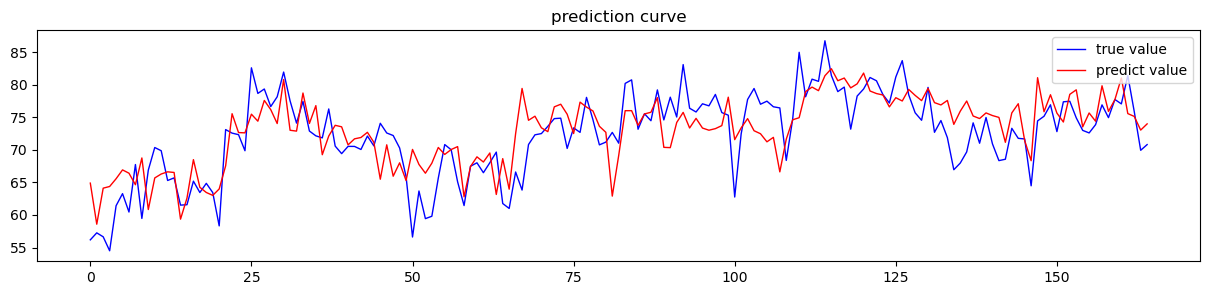

MSE:  19.357464600077737
RMSE:  4.399711876938959
MAE:  3.406990694802023
R^2:  0.5304283601890026


In [13]:
# Define Optimizer and setup Parameter
# adagrad = Adagrad(learning_rate=0.1)
# # y归一化
# model.compile(optimizer='adagrad', loss='mean_squared_error', metrics=['mse'])


model = model_built(conv_layers=2, input_shape=(collecting_number, variable_number, 1), mlp_layers=5)

# y未归一化
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

# Run/Fireup network
nb_epoch = 100
batch_size = 32

# EarlyStop=EarlyStopping(monitor='mse', patience=2,verbose=1, mode='min')
Reduce=ReduceLROnPlateau(monitor='mse',
                         factor=0.5,
                         patience=3,
                         verbose=1,
                         mode='auto',
                         min_delta=0.0001,
                         cooldown=0,
                         min_lr=1e-10)

# y未归一化
model_conv2d = model.fit(x=X_train_r, y=y_train, epochs=nb_epoch, batch_size=batch_size, callbacks=[Reduce])

his = model_conv2d.history
plt.plot(range(1, nb_epoch+1), his['loss'])

y_train_pre = model.predict(X_train_r)
plot_curve(y_train, y_train_pre)

y_test_pre = model.predict(X_test_r)
plot_curve(y_test, y_test_pre)

25/25 [==============================] - 0s 3ms/step


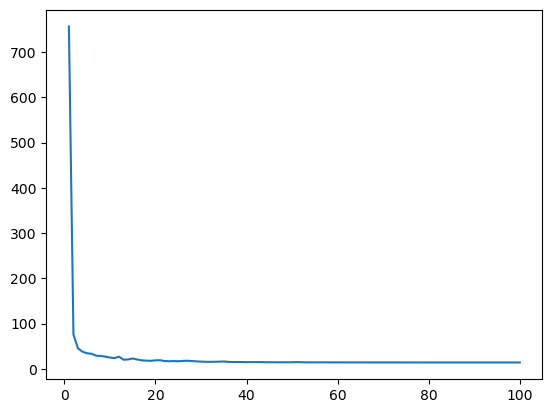

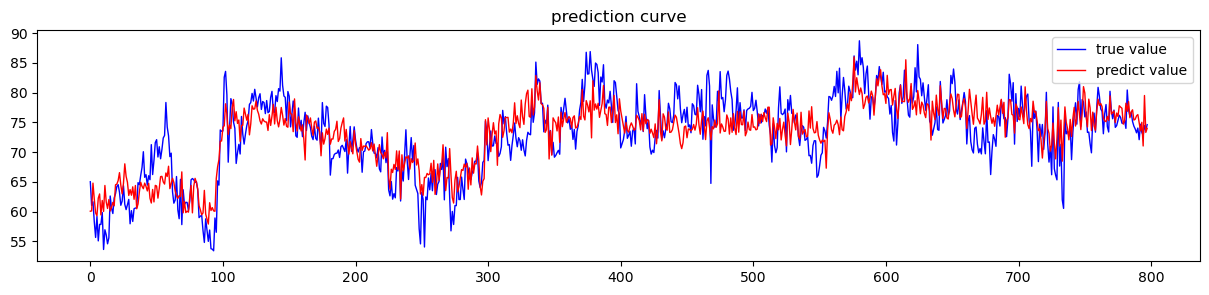

MSE:  14.03592779077144
RMSE:  3.7464553635098126
MAE:  2.94993336679559
R^2:  0.682589485061377
6/6 [==============================] - 0s 3ms/step


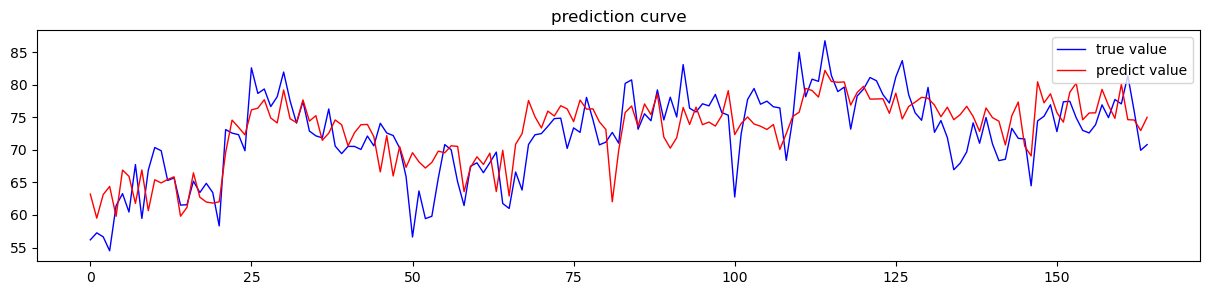

MSE:  17.05413299669413
RMSE:  4.129664998119597
MAE:  3.2767290815133747
R^2:  0.5863023716039579


25/25 [==============================] - 0s 5ms/step


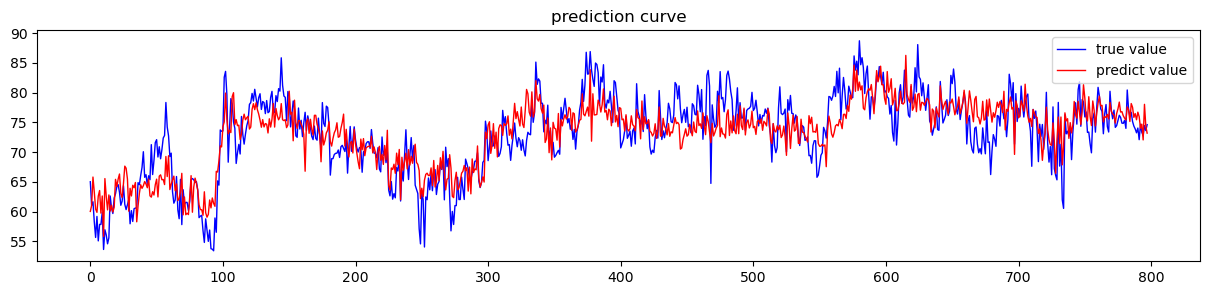

MSE:  13.84075026618019
RMSE:  3.720315882580428
MAE:  2.954482955114226
R^2:  0.687003258023766
6/6 [==============================] - 0s 4ms/step


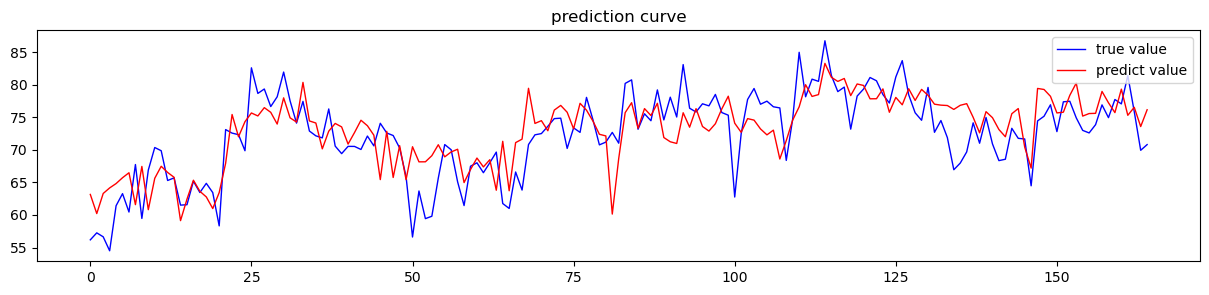

MSE:  18.766319885089782
RMSE:  4.332011067055321
MAE:  3.39846713375207
R^2:  0.544768295656656


In [ ]:
# # save results
# pickle.dump(y_test_pre, open('./results_save/predictions_conv2d.pkl', 'wb'))

In [ ]:
# # save model
# model.save('./save_model/modeI_conv2d.h5')

In [ ]:
# 画中间的输出
def explain_intermediate(layer_name, shape):
    layer = model.get_layer(layer_name).output
    intermediate_layer_model = Model(inputs=model.input, outputs=layer)
    # pre train and test for conv1d layer
    output_train = intermediate_layer_model.predict(X_train)
    output_test = intermediate_layer_model.predict(X_test)
    print(output_train.shape)
    print(output_test.shape)
    
    plt.figure(figsize=(12, output_train.shape[3]))
    for i in range(0, output_train.shape[3]):
        plt.subplot(int(output_train.shape[3]/4), 4, i+1)
        plt.imshow(output_train[4,:,:,i].reshape(shape))
        plt.title(f'Channel-{i}')
    plt.colorbar()
    plt.show()

(798, 263, 19, 16)
(165, 263, 19, 16)


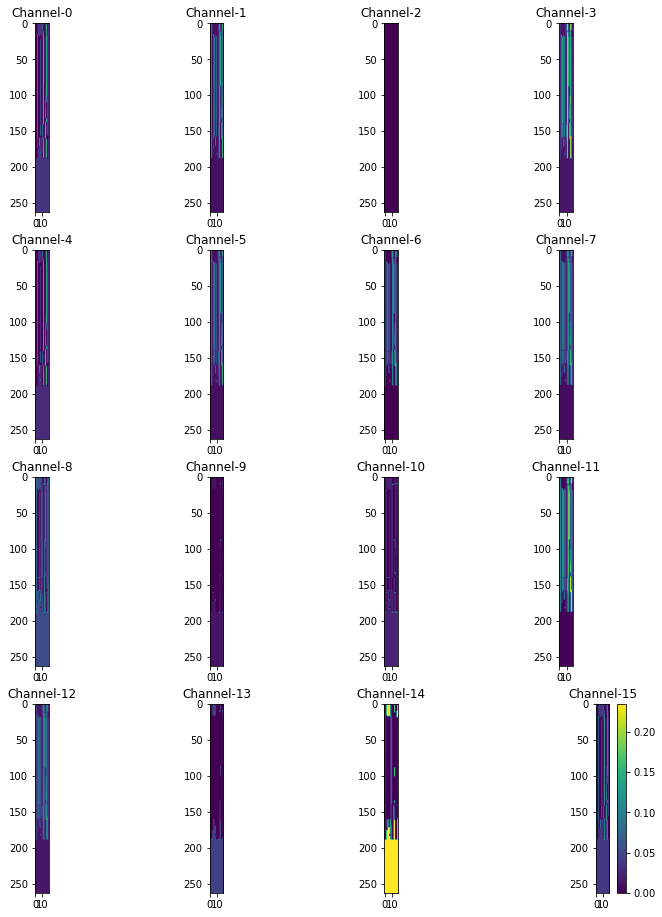

In [ ]:
explain_intermediate(layer_name='active1', shape=(263,19))

(798, 132, 10, 32)
(165, 132, 10, 32)


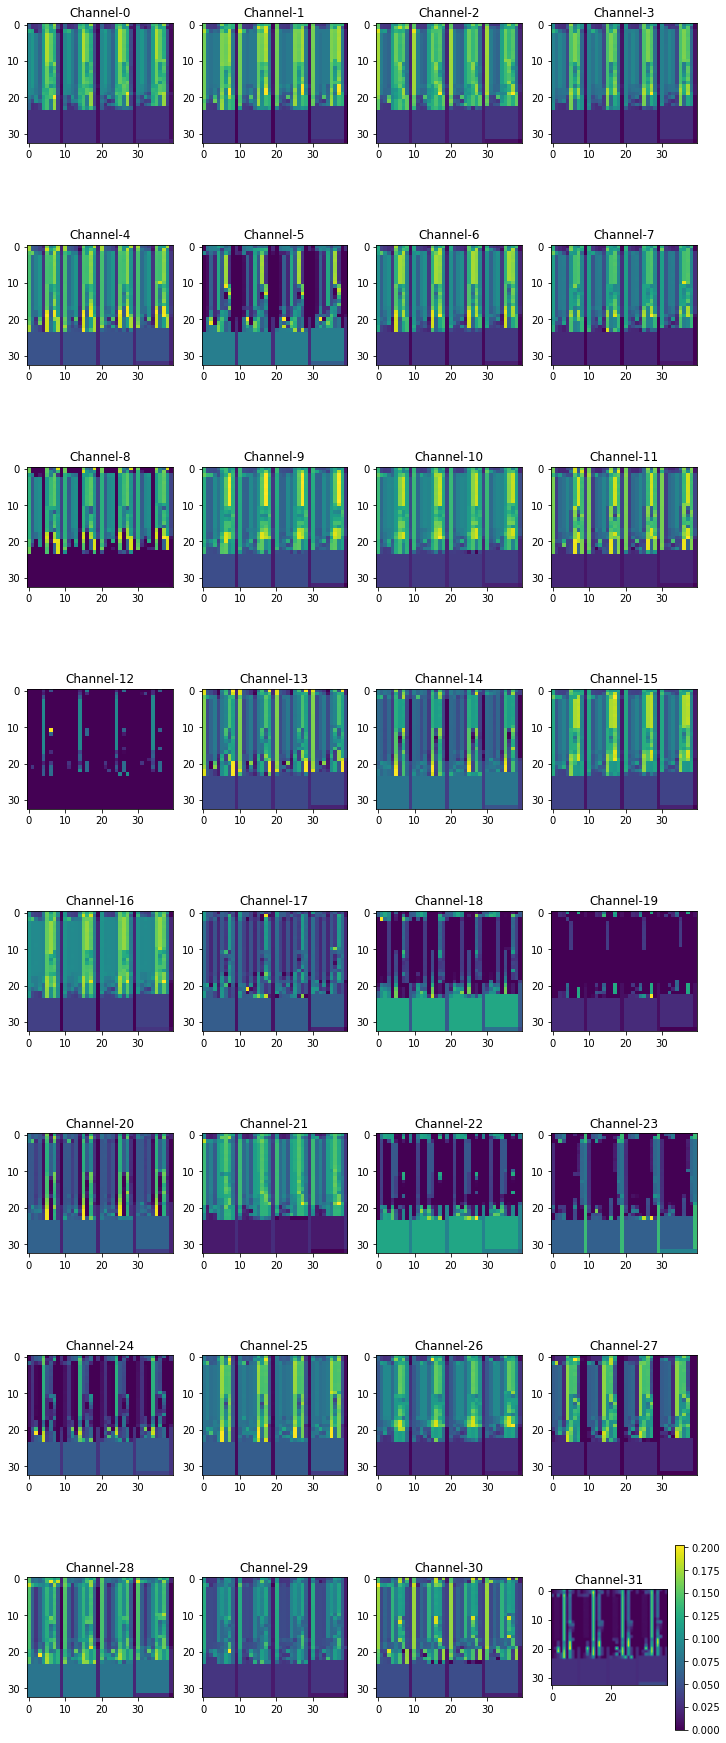

In [ ]:
explain_intermediate(layer_name='active2', shape=(33,40))

(798, 66, 5, 64)
(165, 66, 5, 64)


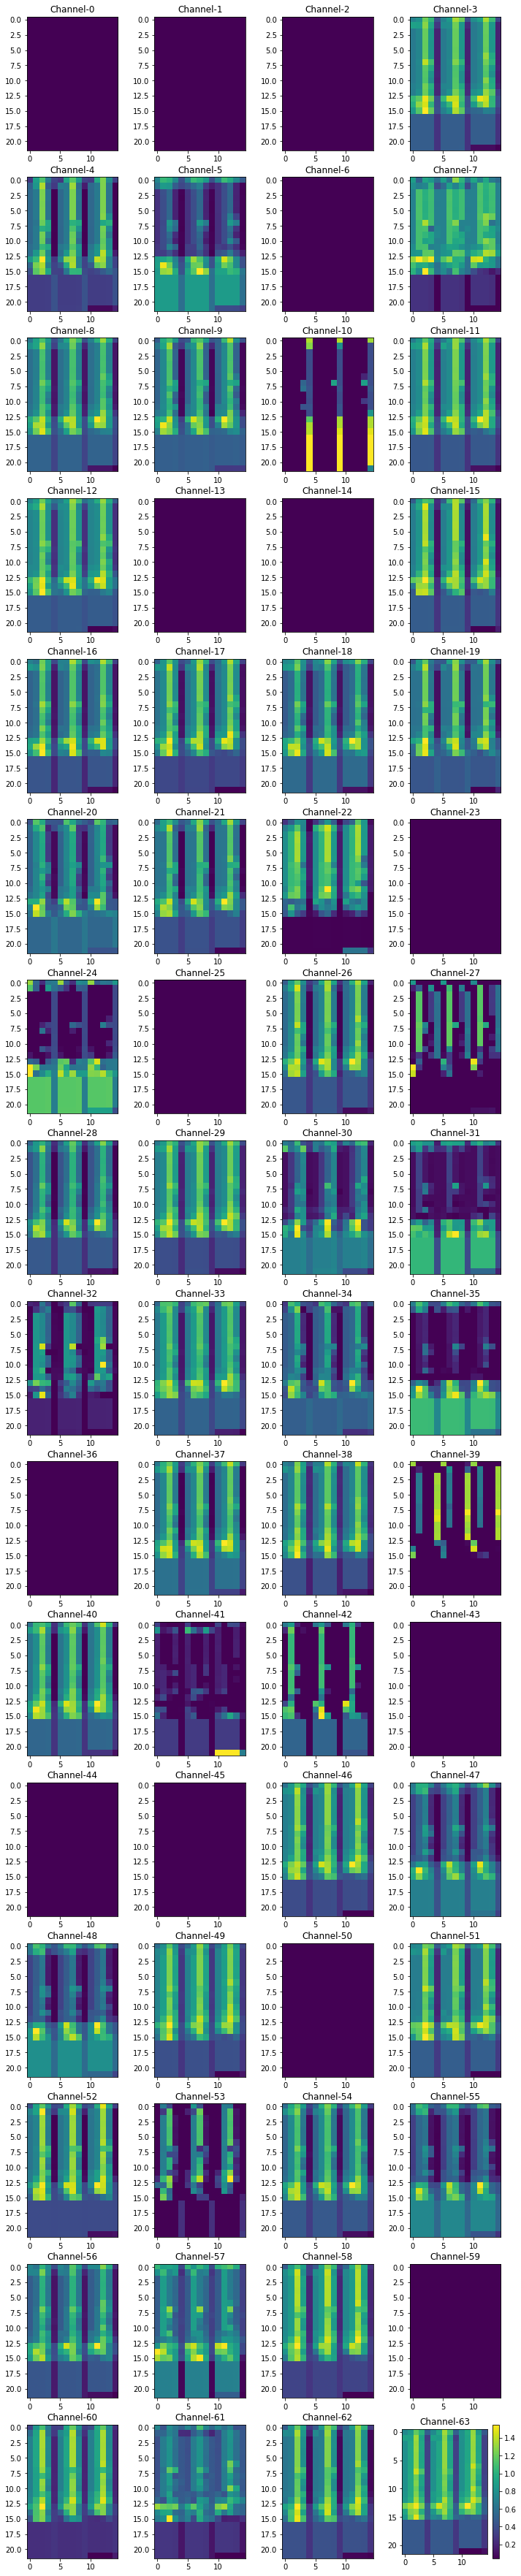

In [ ]:
explain_intermediate(layer_name='active3', shape=(22,15))

(798, 33, 3, 16)
(165, 33, 3, 16)


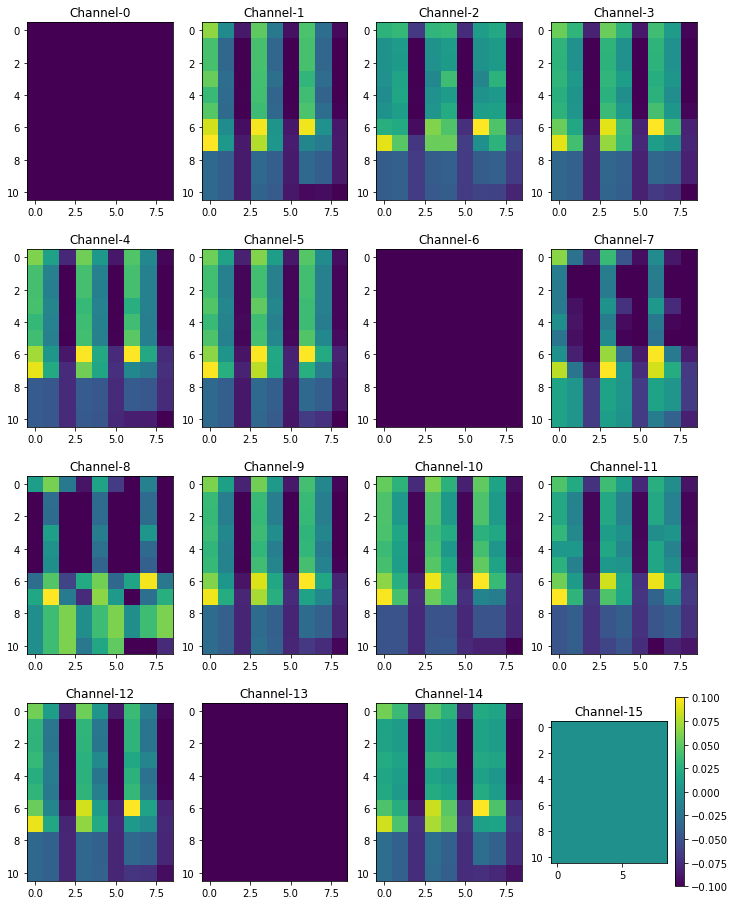

In [ ]:
explain_intermediate(layer_name='active4', shape=(11,9))

(165, 33, 3, 16)


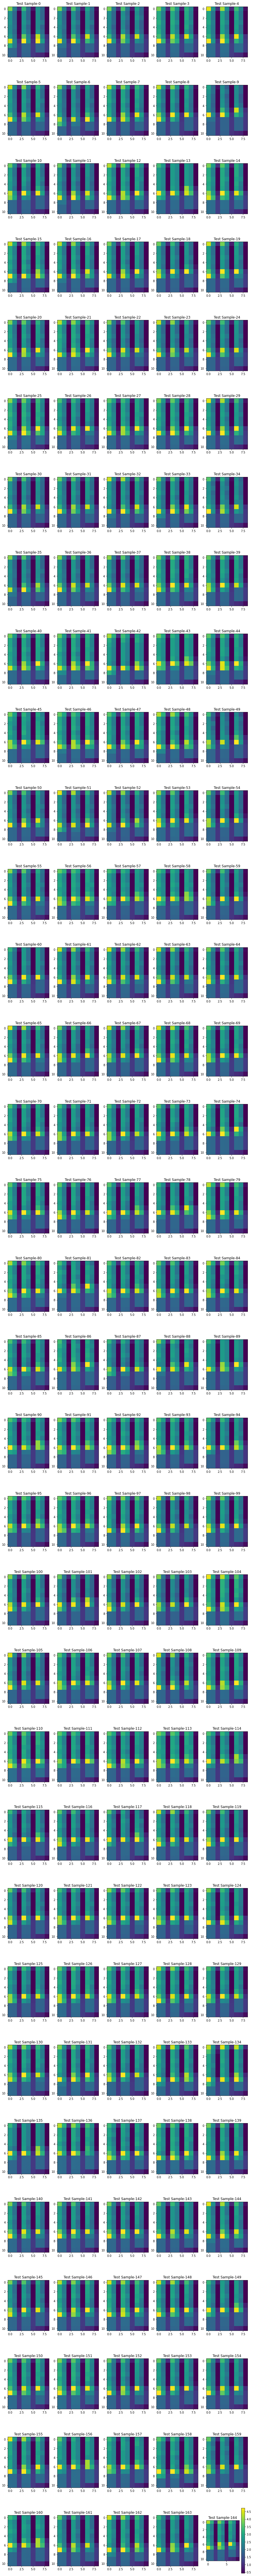

In [ ]:
# 画中间的输出特征，取出来平均值
def extract_intermediate_by_sample(layer_name, shape):
layer_name = 'active4'
shape = (11,9)

layer = model.get_layer(layer_name).output
intermediate_layer_model = Model(inputs=model.input, outputs=layer)
output_test = intermediate_layer_model.predict(X_test)
print(output_test.shape)

images = output_test.mean(axis=3)
plt.figure(figsize=(15, 165))
for i in range(0,165):
    plt.subplot(33,5, i+1)
    plt.imshow(images[i].reshape(shape))
    plt.title(f'Test Sample-{i}')
plt.colorbar()
plt.show()

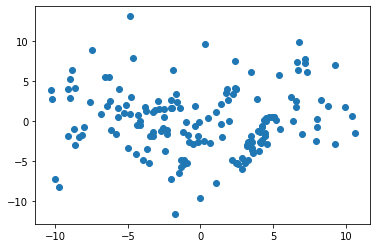

In [ ]:
# 降维到PCA之后效果还不错
data = images.reshape((165,99))
ss = StandardScaler()
pca = PCA(n_components=2)
data_reduced = pca.fit_transform(ss.fit_transform(data))

plt.figure()
plt.scatter(data_reduced[:,0], data_reduced[:,1])
plt.show()

/Users/lihan/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/lihan/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


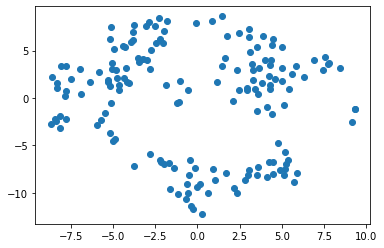

In [ ]:
ss = StandardScaler()
tsne = TSNE(n_components=2)
data_reduced = tsne.fit_transform(ss.fit_transform(data))

plt.figure()
plt.scatter(data_reduced[:,0], data_reduced[:,1])
plt.show()